# $$\text{INFORMAÇÕES SOBRE O CÓDIGO:}$$
- ## Cada célula deste código descreve e executa cada uma das etapas necessárias para a implementação da atividade.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Sinal de áudio

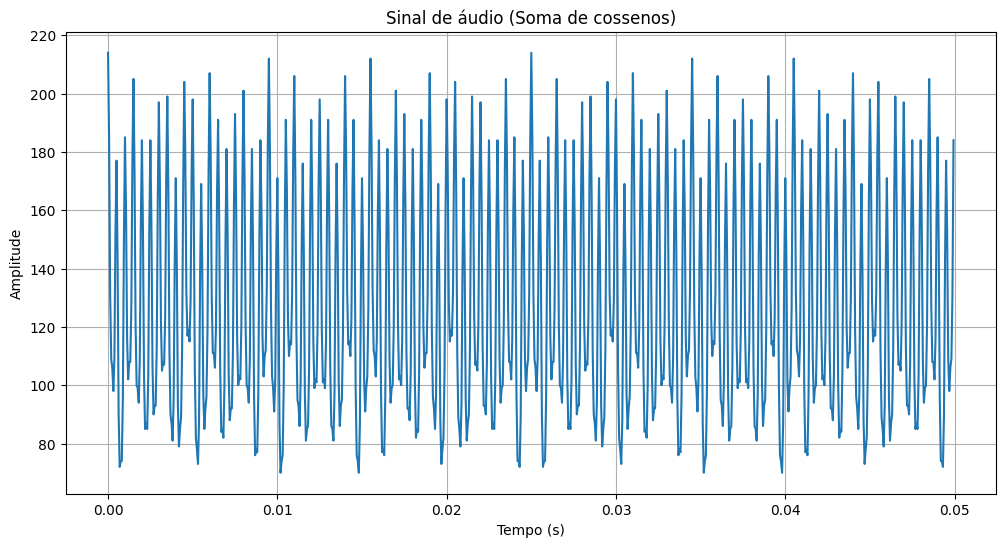

In [91]:
sample_rate, data = wavfile.read('sinal_1.wav')

time  = np.linspace(0.0, (1/sample_rate)*len(data), len(data))
visual_time = 0.05 # Tempo de visualização, pois há muitas amostras para plotar
n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas

plt.figure(figsize=(12, 6))
plt.plot(time[:n_samples], data[:n_samples])
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de áudio (Soma de cossenos)")
plt.grid()
plt.show()

# Determinando as componentes de frequência via FFT da biblioteca numpy

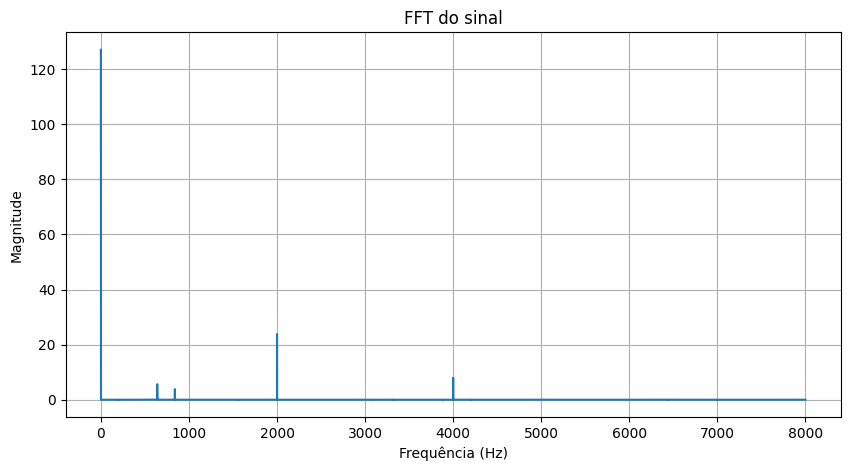

In [92]:
N = len(data)

# Calculando a FFT
fft_result = np.fft.fft(data)
fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2
fft_freqs = fft_freqs[:half_N]
fft_magnitude = np.abs(fft_result[:half_N]) / N  
# Plot
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_magnitude)
plt.title('FFT do sinal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [93]:
# Índices das 5 maiores amplitudes
top5_idx = np.argsort(fft_magnitude)[-6:]

# Frequências correspondentes
top5_freqs = fft_freqs[top5_idx]
top5_mags = fft_magnitude[top5_idx]

# Exibindo os resultados
for f, m in zip(top5_freqs, top5_mags):
    print(f'Frequência: {f:.2f} Hz, Magnitude: {m:.3f}')


Frequência: 839.99 Hz, Magnitude: 3.853
Frequência: 640.03 Hz, Magnitude: 4.428
Frequência: 639.98 Hz, Magnitude: 5.644
Frequência: 4000.00 Hz, Magnitude: 7.951
Frequência: 2000.00 Hz, Magnitude: 23.821
Frequência: 0.00 Hz, Magnitude: 127.029


# Determinando as componentes de frequência via DFT implementada na disciplina

In [94]:
N = 2**10 # Tamanho da DFT

k = np.array([np.arange(0, N)]) # Número de amostras
n = np.arange(0, N) # Índice do somatório
k_T = k.reshape(-1, 1) # Número de amostras organizadas como uma matriz Nx1

In [95]:
func = data[:N]
func_T = func.reshape(-1, 1) # Amostras organizadas como uma matriz Nx1

Wn = np.exp(-2j*np.pi/N) # Definição de Wn

M_result = Wn**(k_T*n) # Matriz com as exponenciais complexas

DFT = M_result @ func_T

[Text(0.0, 0, '0'),
 Text(0.7853981633974483, 0, '$\\pi/4$'),
 Text(1.5707963267948966, 0, '$\\pi/2$'),
 Text(2.356194490192345, 0, '$3\\pi/4$'),
 Text(3.141592653589793, 0, '$\\pi$')]

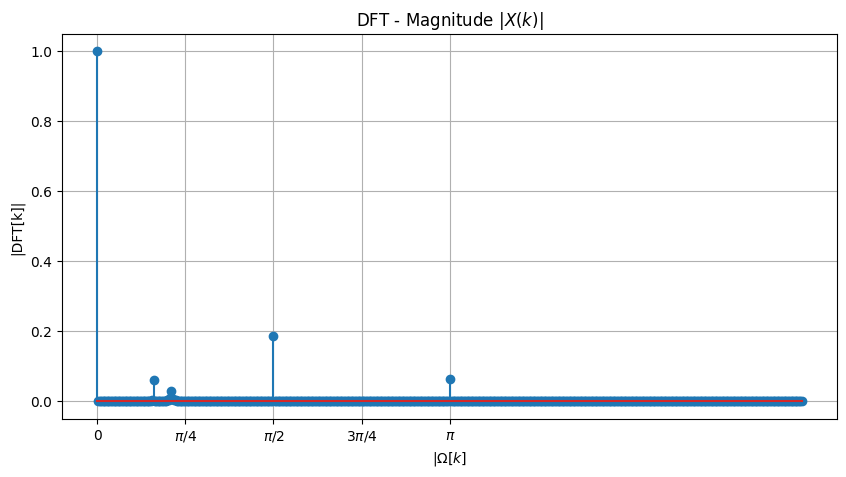

In [96]:
xticks = [0, np.pi/4, np.pi/2, (3*np.pi)/4, np.pi]
xticklabels = ['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
DFT = DFT.flatten()
# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2

fig, axs  = plt.subplots(1, 1, figsize=(10,5))

axs.stem(2*np.pi*k_T[:half_N]/half_N, np.abs(DFT[:half_N])/np.abs(DFT.max()))
axs.set_xlabel('$|\Omega[k]$')
axs.set_ylabel('|DFT[k]|')
axs.grid()
axs.set_title('DFT - Magnitude |$X(k)$|')
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels)
# axs.set_ylim([0,0.029])

## Frequência de cada componente

In [97]:
amplitude = abs(DFT.flatten())/abs(DFT.max())
DFT_freq = np.array([])
j = 0
for i in amplitude[:N//2]:
    if (i >= 0.027):
        DFT_freq = np.append(DFT_freq, (j/N)*sample_rate)
    j += 1
print(DFT_freq,'Hz')

[   0.     640.625  843.75  2000.    4000.   ] Hz
